In [1]:
%matplotlib inline

import os, sys, glob, shutil
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import argparse
import yaml
import json
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
import pyworld as pw
from tqdm.notebook import tqdm


In [2]:
%cd "D:\Schoolwork\TERM 3\WORK\visual_prosody"

D:\Schoolwork\TERM 3\WORK\visual_prosody


In [3]:
def expand(values, durations):
    out = list()
    for value, d in zip(values, durations):
        out += [value] * max(0, int(d))
    return np.array(out)

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--restore_step", type=int, default=0)
parser.add_argument(
    "-p",
    "--preprocess_config",
    type=str,
    required=True,
    help="path to preprocess.yaml",
)
parser.add_argument(
    "-m", "--model_config", type=str, required=True, help="path to model.yaml"
)
parser.add_argument(
    "-t", "--train_config", type=str, required=True, help="path to train.yaml"
)

argString = '-p ./config/Ego4D_final_v6/0726a_preprocess.yaml -m ./config/Ego4D_final_v6/0726a_model.yaml -t ./config/Ego4D_final_v6/0726a_train.yaml'
# args = parser.parse_args()
args = parser.parse_args(argString.split())

In [5]:
from utils.model import get_model, get_vocoder, get_param_num
from utils.tools import to_device, log, synth_one_sample
from model import FastSpeech2Loss
from dataset import Dataset, VideoDataset
from utils.auto_tqdm import tqdm
from evaluate import evaluate

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
config = yaml.load(open(args.preprocess_config, "r"), Loader=yaml.FullLoader)

# Read Config
preprocess_config = yaml.load(
    open(args.preprocess_config, "r"), Loader=yaml.FullLoader
)
model_config = yaml.load(open(args.model_config, "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open(args.train_config, "r"), Loader=yaml.FullLoader)
configs = (preprocess_config, model_config, train_config)

In [7]:
print("Prepare training ...")
preprocess_config, model_config, train_config = configs

Prepare training ...


In [8]:
n_history_vecs = preprocess_config['preprocessing']['video_info']['n_history_vecs']
video_fps = preprocess_config['preprocessing']['video_info']['video_fps']
feature_window_size = preprocess_config['preprocessing']['video_info']['feature_window_size']
feature_stride = preprocess_config['preprocessing']['video_info']['feature_stride']
audio_hop_size = 256
audio_sample_rate = 22050

In [9]:
with open(
    os.path.join(preprocess_config["path"]["preprocessed_path"], "stats.json")
) as f:
    stats = json.load(f)
    stats = stats["pitch"] + stats["energy"]

In [10]:
(
    p_min, p_max, p_mean, p_std, 
    e_min, e_max, e_mean, e_std,
) = stats

In [11]:
split_txt_train_path = f"{preprocess_config['path']['preprocessed_path']}/train.txt"
train_uids = []
with open(split_txt_train_path) as file:
    for line in file:
        # print(line.split('|')[0])
        train_uids.append(line.split('|')[0])

In [12]:
split_txt_val_path = f"{preprocess_config['path']['preprocessed_path']}/val.txt"
val_uids = []
with open(split_txt_val_path) as file:
    for line in file:
        # print(line.split('|')[0])
        val_uids.append(line.split('|')[0])

In [13]:
def compute_deltas_with_last_zero(tensor):
    shifted_tensor = np.roll(tensor, shift=-1, axis=-1)
    deltas = shifted_tensor - tensor
    # Set the last element in each row to 0
    deltas[..., -1] = 0
    return deltas

## train

In [14]:
train_df = pd.read_csv(f"./Data/Ego4D_final_v6/final_dataset_v6/utterances_final_train_v6.csv")

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30553 entries, 0 to 30552
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   utterance_id      30553 non-null  object 
 1   video_id          30553 non-null  object 
 2   person_id         30553 non-null  int64  
 3   video_start_time  30553 non-null  float64
 4   video_end_time    30553 non-null  float64
 5   transcription     30553 non-null  object 
 6   sample_duration   30553 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.6+ MB


634b2f0d-2cca-4bc6-bb13-905c0c2748e7


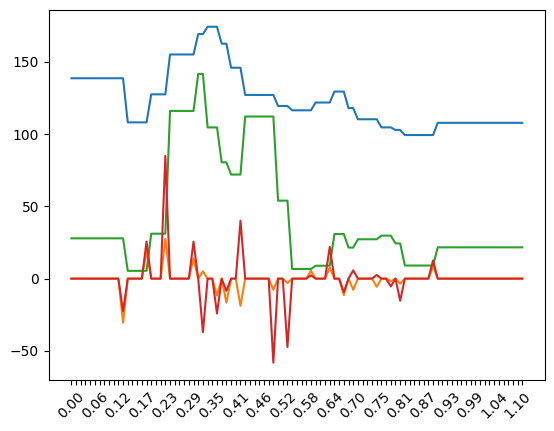

In [16]:
%matplotlib inline
uid = train_uids[0]
pitch_path = f'./preprocessed_data/Ego4D_final_v6/pitch/train/Ego4D_final_v6-pitch-{uid}.npy'
energy_path = f'./preprocessed_data/Ego4D_final_v6/energy/train/Ego4D_final_v6-energy-{uid}.npy'
duration_path = f'./preprocessed_data/Ego4D_final_v6/duration/train/Ego4D_final_v6-duration-{uid}.npy'
wav_path = f"./raw_data/Ego4D_final_v6/train/Ego4D_final_v6/{uid}.wav"
video_emb_path = f'./preprocessed_data/Ego4D_final_v6/video_embedding/train/{uid}.npy'
print(uid)
p_array = np.load(pitch_path)
e_array = np.load(energy_path)
d_array = np.load(duration_path)
p_array = p_array * p_std + p_mean
e_array = e_array * e_std + e_mean
p_seq = expand(p_array, d_array)
e_seq = expand(e_array, d_array)
wav, _ = torchaudio.load(wav_path)
p, t = pw.dio(
    wav.reshape(-1).numpy().astype(np.float64),
    22050,
    frame_period=256 / 22050 * 1000, # ms, windowsize = 256 samples
)
p = pw.stonemask(wav.reshape(-1).numpy().astype(np.float64),
                     p, t, 22050)
plt.plot(p_seq)
plt.plot(compute_deltas_with_last_zero(p_seq))
plt.plot(e_seq)
plt.plot(compute_deltas_with_last_zero(e_seq))
# plt.plot(p)
idxs = np.arange(p_seq.shape[0])
plt.xticks(idxs, labels=[f'{idx*256/22050:.2f}' if idx%5==0 else '' for idx in idxs], rotation=45)
plt.show()

In [17]:
# vid = train_df[train_df['utterance_id']==uid]['video_id'].values[0]
# video_start_time = vid = train_df[train_df['utterance_id']==uid]['video_start_time'].values[0]

In [18]:
%time

uids = []
vids = []
embedding_video_start_times = []
embedding_seq_nohistory_idxs = []
avg_pitchs = []
avg_pitch_deltas = []
avg_energys = []
avg_energy_deltas = []
pitch_means = []
pitch_stds = []
energy_means = []
energy_stds = []
embeddings = []

skipped_counter = 0







for uid in tqdm(train_uids):
    pitch_path = f'./preprocessed_data/Ego4D_final_v6/pitch/train/Ego4D_final_v6-pitch-{uid}.npy'
    energy_path = f'./preprocessed_data/Ego4D_final_v6/energy/train/Ego4D_final_v6-energy-{uid}.npy'
    duration_path = f'./preprocessed_data/Ego4D_final_v6/duration/train/Ego4D_final_v6-duration-{uid}.npy'
    wav_path = f"./raw_data/Ego4D_final_v6/train/Ego4D_final_v6/{uid}.wav"
    video_emb_path = f'./preprocessed_data/Ego4D_final_v6/video_embedding/train/{uid}.npy'
    p_array = np.load(pitch_path)
    e_array = np.load(energy_path)
    d_array = np.load(duration_path)
    # 注意这里没有还原，依然是normalized的状态
    # p_array = p_array * p_std + p_mean
    # e_array = e_array * e_std + e_mean
    p_seq = expand(p_array, d_array)
    e_seq = expand(e_array, d_array)
    p_delta_seq = compute_deltas_with_last_zero(p_seq)
    e_delta_seq = compute_deltas_with_last_zero(e_seq)

    video_emb = np.load(video_emb_path)
    vid = train_df[train_df['utterance_id']==uid]['video_id'].values[0]
    video_start_time = vid = train_df[train_df['utterance_id']==uid]['video_start_time'].values[0]

    for vidx in range(n_history_vecs, video_emb.shape[0]):
        # print(uid)
        # print('vidx: ', vidx)
        vemb_start_time = (vidx - n_history_vecs) * feature_stride / video_fps
        vemb_end_time = ((vidx - n_history_vecs) * feature_stride + feature_window_size) / video_fps
        # print(f"{vemb_start_time}->{vemb_end_time}")
        embedding_video_start_time = video_start_time + vemb_start_time
        audio_start_frame = vemb_start_time * audio_sample_rate
        audio_end_frame = vemb_end_time * audio_sample_rate
        audio_seq_start_idx = int(audio_start_frame//audio_hop_size)
        audio_seq_end_idx = int(audio_end_frame//audio_hop_size)
        # print(f"{audio_seq_start_idx}->{audio_seq_end_idx}")
        # print(video_emb[vidx].shape)

        if p_seq[audio_seq_start_idx:audio_seq_end_idx].shape[0] == 0:
            audio_seq_end_idx += 1
            
        if p_seq[audio_seq_start_idx:audio_seq_end_idx].shape[0] == 0:
            skipped_counter += 1
            continue


        

        avg_pitch = p_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        avg_pitch_delta = p_delta_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        avg_energy = e_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        avg_energy_delta = e_delta_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        
        uids.append(uid)
        vids.append(vid)
        embedding_video_start_times.append(embedding_video_start_time)
        embedding_seq_nohistory_idxs.append(vidx)
        avg_pitchs.append(avg_pitch)
        avg_pitch_deltas.append(avg_pitch_delta)
        avg_energys.append(avg_energy)
        avg_energy_deltas.append(avg_energy_delta)
        pitch_means.append(p_mean)
        pitch_stds.append(p_std)
        energy_means.append(e_mean)
        energy_stds.append(e_std)
        embeddings.append(video_emb[vidx])
        
print('Complete.')
print(f'Skipped {skipped_counter} embeddings.')

CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/27292 [00:00<?, ?it/s]

Complete.
Skipped 53664 embeddings.


In [19]:
train_reverse_df = pd.DataFrame(
    {
        'uid': uids,
        'vid': vids,
        'embedding_video_start_time': embedding_video_start_times,
        'embedding_seq_nohistory_idx': embedding_seq_nohistory_idxs,
        'avg_pitch': avg_pitchs,
        'avg_pitch_delta': avg_pitch_deltas,
        'avg_energy': avg_energys,
        'avg_energy_delta': avg_energy_deltas,
        'pitch_mean': pitch_means,
        'pitch_std': pitch_stds,
        'energy_mean': energy_means,
        'energy_std': energy_stds,
    }
)
train_cat_df = pd.concat([train_reverse_df, pd.DataFrame(np.array(embeddings))], axis=1)

In [20]:
train_cat_df.to_csv('./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv', index=None)

## val

In [21]:
val_df = pd.read_csv(f"./Data/Ego4D_final_v6/final_dataset_v6/utterances_final_val_v6.csv")

In [22]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3046 entries, 0 to 3045
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   utterance_id      3046 non-null   object 
 1   video_id          3046 non-null   object 
 2   person_id         3046 non-null   float64
 3   video_start_time  3046 non-null   float64
 4   video_end_time    3046 non-null   float64
 5   transcription     3046 non-null   object 
 6   sample_duration   3046 non-null   float64
dtypes: float64(4), object(3)
memory usage: 166.7+ KB


9d58583c-20de-439d-b1cd-9c2265bdedd8


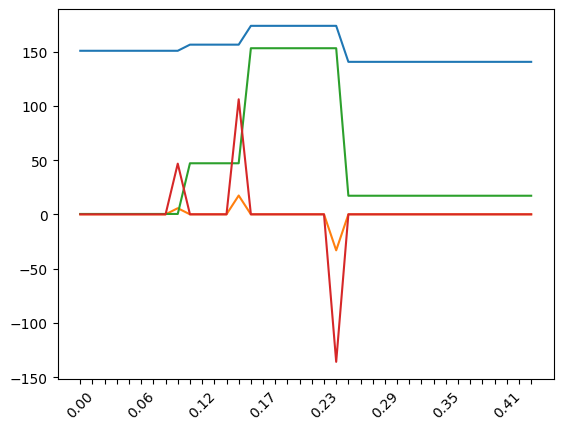

In [23]:
%matplotlib inline
uid = val_uids[0]
pitch_path = f'./preprocessed_data/Ego4D_final_v6/pitch/val/Ego4D_final_v6-pitch-{uid}.npy'
energy_path = f'./preprocessed_data/Ego4D_final_v6/energy/val/Ego4D_final_v6-energy-{uid}.npy'
duration_path = f'./preprocessed_data/Ego4D_final_v6/duration/val/Ego4D_final_v6-duration-{uid}.npy'
wav_path = f"./raw_data/Ego4D_final_v6/val/Ego4D_final_v6/{uid}.wav"
video_emb_path = f'./preprocessed_data/Ego4D_final_v6/video_embedding/val/{uid}.npy'
print(uid)
p_array = np.load(pitch_path)
e_array = np.load(energy_path)
d_array = np.load(duration_path)
p_array = p_array * p_std + p_mean
e_array = e_array * e_std + e_mean
p_seq = expand(p_array, d_array)
e_seq = expand(e_array, d_array)
wav, _ = torchaudio.load(wav_path)
p, t = pw.dio(
    wav.reshape(-1).numpy().astype(np.float64),
    22050,
    frame_period=256 / 22050 * 1000, # ms, windowsize = 256 samples
)
p = pw.stonemask(wav.reshape(-1).numpy().astype(np.float64),
                     p, t, 22050)
plt.plot(p_seq)
plt.plot(compute_deltas_with_last_zero(p_seq))
plt.plot(e_seq)
plt.plot(compute_deltas_with_last_zero(e_seq))
# plt.plot(p)
idxs = np.arange(p_seq.shape[0])
plt.xticks(idxs, labels=[f'{idx*256/22050:.2f}' if idx%5==0 else '' for idx in idxs], rotation=45)
plt.show()

In [24]:
# vid = train_df[train_df['utterance_id']==uid]['video_id'].values[0]
# video_start_time = vid = train_df[train_df['utterance_id']==uid]['video_start_time'].values[0]

In [25]:
%time

uids = []
vids = []
embedding_video_start_times = []
embedding_seq_nohistory_idxs = []
avg_pitchs = []
avg_pitch_deltas = []
avg_energys = []
avg_energy_deltas = []
pitch_means = []
pitch_stds = []
energy_means = []
energy_stds = []
embeddings = []
skipped_counter = 0







for uid in tqdm(val_uids):
    pitch_path = f'./preprocessed_data/Ego4D_final_v6/pitch/val/Ego4D_final_v6-pitch-{uid}.npy'
    energy_path = f'./preprocessed_data/Ego4D_final_v6/energy/val/Ego4D_final_v6-energy-{uid}.npy'
    duration_path = f'./preprocessed_data/Ego4D_final_v6/duration/val/Ego4D_final_v6-duration-{uid}.npy'
    wav_path = f"./raw_data/Ego4D_final_v6/val/Ego4D_final_v6/{uid}.wav"
    video_emb_path = f'./preprocessed_data/Ego4D_final_v6/video_embedding/val/{uid}.npy'
    p_array = np.load(pitch_path)
    e_array = np.load(energy_path)
    d_array = np.load(duration_path)
    # 注意这里没有还原，依然是normalized的状态
    # p_array = p_array * p_std + p_mean
    # e_array = e_array * e_std + e_mean
    p_seq = expand(p_array, d_array)
    e_seq = expand(e_array, d_array)
    p_delta_seq = compute_deltas_with_last_zero(p_seq)
    e_delta_seq = compute_deltas_with_last_zero(e_seq)

    video_emb = np.load(video_emb_path)
    vid = val_df[val_df['utterance_id']==uid]['video_id'].values[0]
    video_start_time = vid = val_df[val_df['utterance_id']==uid]['video_start_time'].values[0]

    for vidx in range(n_history_vecs, video_emb.shape[0]):
        # print(uid)
        # print('vidx: ', vidx)
        vemb_start_time = (vidx - n_history_vecs) * feature_stride / video_fps
        vemb_end_time = ((vidx - n_history_vecs) * feature_stride + feature_window_size) / video_fps
        # print(f"{vemb_start_time}->{vemb_end_time}")
        embedding_video_start_time = video_start_time + vemb_start_time
        audio_start_frame = vemb_start_time * audio_sample_rate
        audio_end_frame = vemb_end_time * audio_sample_rate
        audio_seq_start_idx = int(audio_start_frame//audio_hop_size)
        audio_seq_end_idx = int(audio_end_frame//audio_hop_size)
        # print(f"{audio_seq_start_idx}->{audio_seq_end_idx}")
        # print(video_emb[vidx].shape)

        if p_seq[audio_seq_start_idx:audio_seq_end_idx].shape[0] == 0:
            audio_seq_end_idx += 1
            
        if p_seq[audio_seq_start_idx:audio_seq_end_idx].shape[0] == 0:
            skipped_counter += 1
            continue


        

        avg_pitch = p_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        avg_pitch_delta = p_delta_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        avg_energy = e_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        avg_energy_delta = e_delta_seq[audio_seq_start_idx:audio_seq_end_idx].mean()
        
        uids.append(uid)
        vids.append(vid)
        embedding_video_start_times.append(embedding_video_start_time)
        embedding_seq_nohistory_idxs.append(vidx)
        avg_pitchs.append(avg_pitch)
        avg_pitch_deltas.append(avg_pitch_delta)
        avg_energys.append(avg_energy)
        avg_energy_deltas.append(avg_energy_delta)
        pitch_means.append(p_mean)
        pitch_stds.append(p_std)
        energy_means.append(e_mean)
        energy_stds.append(e_std)
        embeddings.append(video_emb[vidx])
        
print('Complete.')
print(f'Skipped {skipped_counter} embeddings.')

CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/2772 [00:00<?, ?it/s]

Complete.
Skipped 4886 embeddings.


In [26]:
val_reverse_df = pd.DataFrame(
    {
        'uid': uids,
        'vid': vids,
        'embedding_video_start_time': embedding_video_start_times,
        'embedding_seq_nohistory_idx': embedding_seq_nohistory_idxs,
        'avg_pitch': avg_pitchs,
        'avg_pitch_delta': avg_pitch_deltas,
        'avg_energy': avg_energys,
        'avg_energy_delta': avg_energy_deltas,
        'pitch_mean': pitch_means,
        'pitch_std': pitch_stds,
        'energy_mean': energy_means,
        'energy_std': energy_stds,
    }
)
val_cat_df = pd.concat([val_reverse_df, pd.DataFrame(np.array(embeddings))], axis=1)

In [27]:
val_cat_df.to_csv('./jupyter_walkthrough/side_exp/video_to_prosody_v6_val.csv', index=None)

In [30]:
train_cat_df.shape

(118201, 1548)

In [30]:
np.array(embeddings).shape

(9566, 1536)

In [37]:
cat = pd.concat([val_reverse_df, pd.DataFrame(np.array(embeddings))], axis=1)

In [38]:
cat.shape

(9566, 1549)